<a href="https://colab.research.google.com/github/RaminTK/TDRP/blob/main/VRP_2T2D_v7(Oct01).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Improvements compared to v3:

- Multi Truck / Multi UAV - done
- Overlap on UAV and Truck path - done

- Capacitated UAV - done

- Unassigned or assigned (Unassigned now, we may have both and compare, just make all u values t to make it assigned, obviously unassigned is more complex and may give better solution) - done

- Meet at S - done

- Multi depot visit by UAV (needs more than one depot visit, r_u and p_u must accept several depot visit time) (if we have large enough number of truck nodes to visit uav and truck, we may do not need depot visit by UAV)(ignore for now, discuss with Nafiseh on this)


In [ ]:
# !pip install gurobipy

# Libraries

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

In [ ]:
# Create an environment with your WLS license
params = {
"WLSACCESSID": 'c5c6ef9a-d24b-4e09-99ba-a30fae3c2de1',
"WLSSECRET": '3809b277-8064-4385-8804-9971d3dc9938',
"LICENSEID": 2536865,
}

# env = gp.Env(params=params)

# # Create the model within the Gurobi environment
# model = gp.Model(env=env)

# Parameters

$d^{t}_{ij}$ Travel time between node $i$ and $j$ by truck, $(i,j) \in A^t$.

$d^{u}_{ij}$ Travel time between node $i$ and $j$ by UAV, $(i,j) \in A^u$.

$M$ A sufficiently large number.

<!-- $L$ & Battery life limit of UAV. -->

$N$ Total number of aid recipients (bu UAV).

$L$ Number of aid recipients accessible by truck.

$R$ Number of Trucks.

$V$ Number of UAVs.

<!-- $q$ Relief item capacity limit of UAVs. (unlimited) -->

In [ ]:
N = 6  # Total number of aid recipients (bu UAV)
L = 3  # Number of aid recipients accessible by truck
R = 1  # Number of Trucks
V = 1  # Number of UAVs
q = 2  # Relief item capacity limit of UAVs. (unlimited)
M = 100000  # A large number

# Sets


$A^t$  Set of aid recipients served by trucks and depot. $A^t \subset A_U$.

$A^u$  Set of aid recipients served by UAVs and depote (all nodes). $A^u$.

$U$  Set of UAVs. $|U|= V$.

$T$  Set of trucks. $|T| = R$.

In [ ]:
A_T = (list(range(L+1)))+[N+1]  # Set of nodes for trucks
A_U = list(range(N+2))# Set of nodes for UAVs

T = list(range(1,R+1))      # Set of trucks
U = T

## Generate random coordinates for the nodes

In [ ]:
# Number of nodes
N += 1

np.random.seed(0)  # For reproducibility
coordinates = np.random.rand(N, 2) * 100  # Generate random coordinates in a 100x100 area

In [ ]:
coordinates = np.vstack([coordinates, coordinates[0]])

## Distance Matrix


In [ ]:
euclidean_dist_matrix = distance_matrix(coordinates, coordinates)
manhattan_dist_matrix = distance_matrix(coordinates, coordinates, p=1)

In [ ]:
euclidean_df = pd.DataFrame(euclidean_dist_matrix, columns=[f'Node {i}' for i in range(N+1)], index=[f'Node {i}' for i in range(N+1)])
manhattan_df = pd.DataFrame(manhattan_dist_matrix, columns=[f'Node {i}' for i in range(N+1)], index=[f'Node {i}' for i in range(N+1)])

## Plot the nodes

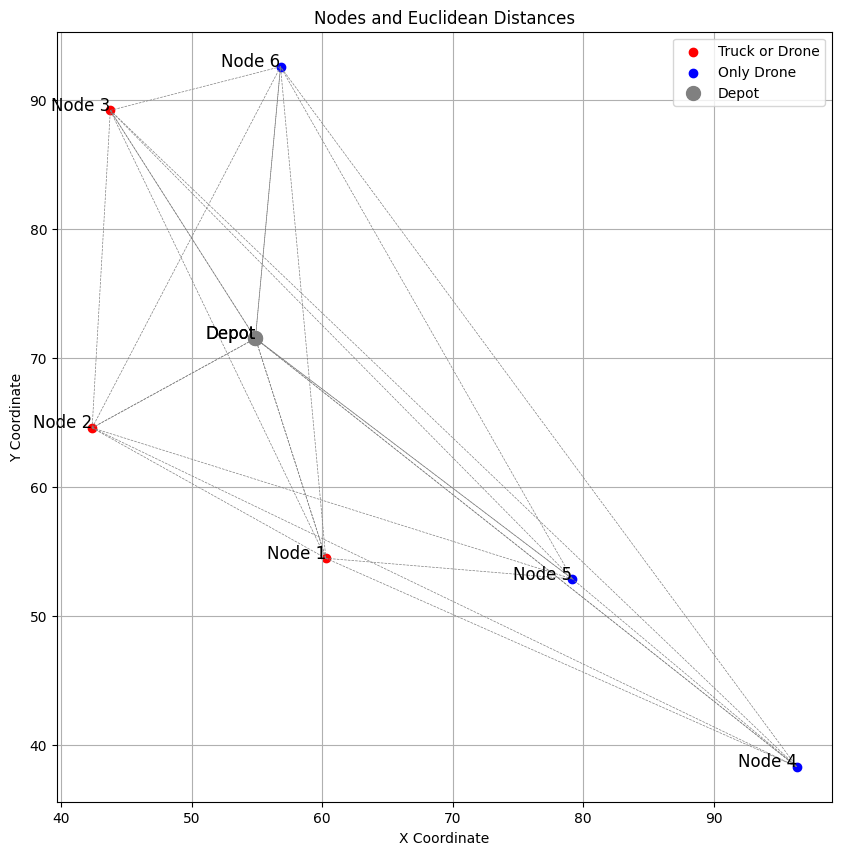

In [ ]:
plt.figure(figsize=(10, 10))
# plt.scatter(coordinates[:, 0], coordinates[:, 1], color='red')
plt.scatter(coordinates[A_T[1:-1], 0], coordinates[A_T[1:-1], 1], color='red', label='Truck or Drone')
plt.scatter(coordinates[[item for item in A_U if item not in A_T], 0], coordinates[[item for item in A_U if item not in A_T], 1], color='blue', label='Only Drone')

# Highlight the first and last points as depots
plt.scatter(coordinates[0, 0], coordinates[0, 1], color='gray', s=100, label='Depot')
plt.scatter(coordinates[-1, 0], coordinates[-1, 1], color='gray', s=100)

# Annotate the nodes
for i, (x, y) in enumerate(coordinates):
    if i == 0:
        plt.text(x, y, 'Depot', fontsize=12, ha='right')
    elif i == len(coordinates) - 1:
        plt.text(x, y, 'Depot', fontsize=12, ha='right')
    else:
        plt.text(x, y, f'Node {i}', fontsize=12, ha='right')

# Draw lines between nodes for Euclidean distances
for i in range(len(coordinates)):
    for j in range(i + 1, N+1):
        plt.plot([coordinates[i, 0], coordinates[j, 0]], [coordinates[i, 1], coordinates[j, 1]], 'gray', linestyle='--', linewidth=0.5)

plt.title('Nodes and Euclidean Distances')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
d_t = manhattan_df  # Travel times for trucks => will change into a matrix of Manhttan distances
d_u = euclidean_df  # Travel times for UAVs => will change into a matrix of  Euclidean distances

# Model

In [ ]:
env = gp.Env(params=params)
m = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2536865
Academic license 2536865 - for non-commercial use only - registered to rt___@stevens.edu


# Indices

$i, j, h, s, g, v$  Equivalently used indices for the nodes of the network (aid recipients and depot).

$t$  Index of trucks.

# Variables

$x^{t}_{ij}$ 1 if truck $t$ moves from node $i$ to node $j$; 0 otherwise. $(i,j) \in A_t, t \in T$.

$y^{t}_{ijs}$ 1 if UAV $u$ moves from node $i$ to node $j$ and meet it's truck on node $s$; 0 otherwise. $(i,j) \in A_U$ s in for $t \in T$.

$z^{t}_{i}$ Position of node $i$ in the truck $t$ route. $i \in A_E$ for $t \in T$.

$r^{t}_{i}$ Arrival time of truck $t$ at node $i$. $i \in A_E$ for $t \in T$.

$p^{t}_{i}$ Departure time of truck $t$ from node $i$. $i \in A_E$ for $t \in T$.

In [ ]:
x = m.addVars(A_T[:-1], A_T[1:], T, vtype=GRB.BINARY,lb=0, name="Truck") #1 if truck $w$ moves from node $i$ to node $j$; 0 otherwise. $(i,j) \in C_0$ for $w \in W$.
y = m.addVars(A_U[:-1], A_U[1:], A_T[1:], U, vtype=GRB.BINARY, lb=0, name="UAV") #1 if UAV $u$ travels from node $i$ to visit node $j$ and returns to the truck $w$ at node $s$; 0 otherwise. $(i,j,s) \in C_0$ for $w \in W$ and $u \in U$.
z_t = m.addVars(A_T[1:-1],T, vtype=GRB.INTEGER,lb=1.0,ub= L, name="truck order") #Position of node $i$ in the truck $w$ route. $i \in C_0$ for $w \in W$.
z_u = m.addVars(A_U[1:-1],U, vtype=GRB.INTEGER,lb=1.0,ub= N, name="uav order") #Position of node $i$ in the uav $t$ route. $i \in A_T$ for $t \in T$.
r_t = m.addVars(A_T,T, vtype=GRB.CONTINUOUS, lb=0.0, name="arrival time truck") #Arrival time of truck $w$ at node $i$. $i \in C_0$ for $w \in W$.
p_t = m.addVars(A_T, T, vtype=GRB.CONTINUOUS, lb=0.0, name="departure time truck") #Departure time of truck $w$ from node $i$. $i \in C_0$ for $w \in W$.
r_u = m.addVars(A_U, U, vtype=GRB.CONTINUOUS, lb=0.0, name="arrival time uav")
p_u = m.addVars(A_U, T, vtype=GRB.CONTINUOUS, lb=0.0, name="departure time uav")
w = m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name="objective")

# Objective Function

Min (Max $(r^t_{it} + r^u_{ju}), \forall i \in A^t,\forall j \in A^u,\forall t \in T,\forall u \in U), $

Min $\sum_{i \in A_T} \sum_{t \in T} r^{t}_{i}$ (1)


In [ ]:
m.setObjective(w, GRB.MINIMIZE)

In [ ]:
m.addConstrs(r_t[i,t] <= w for i in A_T[1:-1] for t in T)
m.addConstrs(r_u[i,u] <= w for i in A_U[1:-1] for u in U)

{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (6, 1): <gurobi.Constr *Awaiting Model Update*>}

# Constraints

$\sum_{j \in A_T} x^{t}_{0j} = 1, \forall t \in T$  (2)

In [ ]:
m.addConstrs((gp.quicksum(x[0, j, t] for j in A_T[1:-1]) == 1 for t in T), "DepartsFromDepot") #done

m.addConstrs((gp.quicksum(y[0, j, s, u] for j in A_U[1:-1] for s in A_T[1:]) <= 1 for u in U), "UAVsFromDepot") #done

{1: <gurobi.Constr *Awaiting Model Update*>}

$\sum_{i \in C_T} x^{t}_{i,end} = 1, \forall t \in T$ (3)

In [ ]:
m.addConstrs((gp.quicksum(x[i, N, t] for i in A_T[1:-1]) == 1 for t in T), "ReturnsToDepot") #done

{1: <gurobi.Constr *Awaiting Model Update*>}

explain - truck self return ban

In [ ]:
m.addConstr(gp.quicksum(x[i, j, t] for t in T for i in A_T[1:-1] for j in A_T[1:-1] if i == j) == 0, "self_return_ban") #done

m.addConstr(gp.quicksum(x[0, N, t] for t in T) == 0, "self return ban") #done

<gurobi.Constr *Awaiting Model Update*>

explain - uav self return ban

In [ ]:
m.addConstr(gp.quicksum(y[i, j, s, u] for s in A_T[1:] for u in U for i in A_U[1:-1] for j in A_U[1:-1] if i == j ) == 0, "self return ban") #done

m.addConstr(gp.quicksum(y[0, N, s, u] for s in A_T[1:] for u in U) == 0, "self return ban") #done

<gurobi.Constr *Awaiting Model Update*>

$\sum_{g \in A_T \atop g \neq i} x^{t}_{gi} = \sum_{j \in A_U \atop j \neq i} x^{t}_{ij}, \forall i \in A_T, \forall t \in T,$ (4)

In [ ]:
m.addConstrs((gp.quicksum(x[g, i, t] for g in A_T[:-1] if g != i) == gp.quicksum(x[i, j, t] for j in A_T[1:] if j != i) for i in A_T[1:-1] for t in T), "FlowConservationTruck") #probably this forces to visit the depote at the end

{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>}

This sets if s is set equal for all or not

In [ ]:
# m.addConstrs((gp.quicksum(y[g, i, s, u] for g in A_U[:-1] if g != i) == gp.quicksum(y[i, j, s, u] for j in A_U[1:] if j != i) for i in A_U[1:-1] for s in A_T[1:] for u in U), "FlowConservationUAV")  #probably this forces to visit the depote at the end
m.addConstrs((gp.quicksum(y[g, i, s, u] for g in A_U[:-1] if g != i for s in A_T[1:]) == gp.quicksum(y[i, j, s, u] for j in A_U[1:] if j != i for s in A_T[1:]) for i in A_U[1:-1] for u in U), "FlowConservationUAV")  #probably this forces to visit the depote at the end


{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (6, 1): <gurobi.Constr *Awaiting Model Update*>}

$\sum_{i \in A_T \atop i \neq j} \sum_{t \in T} x^{t}_{ij} + \sum_{i \in A_U \atop i \neq j} \sum_{s \in A_E} \sum_{u \in U} y^{ut}_{ijs} = 1, \forall j \in A_T,$ (5)


it is only for nodes A_T. we should another one only for nodes unique for A_U (A_U - A_T)

In [ ]:
# m.addConstrs((gp.quicksum(x[i, j, t] for i in A_T[:-1] if i != j for t in T) + gp.quicksum(y[g, j, s, u] for g in A_U[:-1] if g != j for s in A_T[1:] for u in U) == 1 for j in A_T[1:-1]), "VisitOnce - Truck or UAV")

# # Original constraint, but exclude the case when j == s
m.addConstrs((gp.quicksum(x[i, j, t] for i in A_T[:-1] if i != j for t in T) + gp.quicksum(y[g, j, s, u] for g in A_U[:-1] if g != j for s in A_T[1:] if s != j for u in U) == 1 for j in A_T[1:-1]), "VisitOnce Truck or UAV")

# # New constraint for j == s, allowing both x and y to be 1 simultaneously when j == s
# m.addConstrs((gp.quicksum(x[i, j, t] for i in A_T[:-1] if i != j for t in T) + gp.quicksum(y[g, j, s, u] for g in A_U[:-1] if g != j for s in A_T[1:] if s == j for u in U) == 2 for j in A_T[1:-1]), "VisitOnce Truck or UAV")



{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>}

it is only for nodes A_T. we should another one only for nodes unique for A_U (A_U - A_T)

In [ ]:
m.addConstrs((gp.quicksum(y[i, j, s, t] for i in A_U[:-1] if i != j for s in A_T[1:] for t in T) == 1 for j in  list(set(A_U) - set(A_T))), "VisitOnce - UAV")


{4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>}

$1 - (c + 2)(1 - x^{w}_{ij}) \leq z_j - z^{w}_{i}, \forall i \in C_T, \forall j \in C_E, i \neq j, \forall w \in W$ (17)


MTZ for truck

In [ ]:
m.addConstrs(z_t[i,t] - z_t[j,t] + (L) * x[i,j,t] <= L - 1 for i in A_T[1:-1] for j in A_T[1:-1] if i != j for t in T)

{(1, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 2, 1): <gurobi.Constr *Awaiting Model Update*>}

$(c+2) - 1 \leq z_{i} - z_{j} + (c+2) y^{uw}_{ij}, \forall i \in C_{0}, \forall j \in C_E, \forall u \in U, \forall w \in W,$ (16)


MTZ for UAV

In [ ]:
m.addConstrs((z_u[i, u] - z_u[j, u] + (N) * y[i, j, s, u] <= N - 1 for i in A_U[1:-1] for j in A_U[1:-1] if i!= j for s in A_T[1:] for u in U))

{(1, 2, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6, 2, 1): <gurobi.Constr *Awaiting Model Up

$\sum_{h \in A_T \atop h \neq i} x_{hi} + \sum_{g \in A_E \atop g \neq s} x_{gs} \geq 2 \sum_{j \in A_U} y^{ut}_{ijs}, \forall i \in A_T, \forall s \in A_E, \forall u \in U,$ (6)

$\sum_{j \in C_D} y^{uw}_{0js} \leq \sum_{g \in C_T \atop g \neq s} x_{gs}, \forall s \in C_E, \forall u \in U,$ (7)


limit of visiting one node per tour by UAV

must have more constrs for two and three visits

In [ ]:
# m.addConstrs((gp.quicksum(x[h, i, t] for h in A_T[:-1] if h != i) + gp.quicksum(x[g, s, t] for g in A_T[:-1] if g != s) >= 2 * gp.quicksum(y[i, j, s, t] for j in A_U[1:]) for i in A_T[1:-1] for s in A_T[1:] for t in T)) # this is just for S

# m.addConstrs((gp.quicksum(y[0, j, s, t] for j in A_U[1:]) <= gp.quicksum(x[g, s, t] for g in A_T[:-1] if g != s) for s in A_T[1:] for t in T), "UAVRouteConsistency") # this is just for S


 $r^{t}_{j} + d_{ij} - (1 - x^{t}_{ij}) M \leq p^{t}_{j}, \forall i \in A_T, \forall j \in A_E, i \neq j,$ (8)


In [ ]:
m.addConstrs((p_t[i, t] + d_t.iloc[i, j] - (1 - x[i, j, t]) * M <= r_t[j, t] for i in A_T[:-1] for j in A_T[1:] if i != j for t in T), "TruckArrivalTime")

{(0, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 7, 1): <gurobi.Constr *Awaiting Model Update*>}

$\tilde{t}^{u}_{i} + \bar{d}_{ij} - (1 - \sum_{s \in C_E \atop s \neq j} y^{uw}_{ijs}) M \leq \tilde{l}^{u}_{j}, \forall i \in C_D, \forall j \in C, \forall u \in U,$ (9)

In [ ]:
m.addConstrs((p_u[i, u] + d_u.iloc[i, j] - (1 - gp.quicksum(y[i, j, s, u] for s in A_T[1:])) * M <= r_u[j, u] for i in A_U[:-1] for j in A_U[1:] if i != j for u in U), "UAVArrivalTime")

{(0, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 6, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 6, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 7, 1): <gurobi.Constr *Awaiting Model Upd

${p}^{u}_{i} \leq {r}^{u}_{i}, \forall i \in {A}_{U}, \forall u \in U,$ (10)

In [ ]:
m.addConstrs((r_u[i, t] <= p_u[i, t] for i in A_U[1:-1] for t in T), "UAVDepartureTime")

{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (6, 1): <gurobi.Constr *Awaiting Model Update*>}

$p^{t}_{i} \leq r^{t}_{j}, \forall i \in A_T, \forall t \in W,$ (11)

In [ ]:
m.addConstrs((r_t[i, t] <= p_t[i, t] for i in A_T[1:-1] for t in T), "TruckDepartureTime")

{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>}

$\tilde{t}^{u}_{i} - (1 - \sum_{j \in C \atop j \neq i} \sum_{s \in C_E} y^{uw}_{ijs}) M \leq l^{w}_{j}, \forall i \in C_D, \forall u \in U, \forall w \in W,$ (12)

UAV must depart from node i after truck arrives there

In [ ]:
m.addConstrs((r_t[i, t] - (1 - gp.quicksum(y[i, g, s, t] for g in A_U[1:] if g != i for s in A_T[1:])) * M <= p_u[i, t] for i in A_T[:-1] for t in T), "UAVReturnTime1")

{(0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>}

$l^{w}_{s} + \bar{d}_{js} - (1 - \sum_{i \in C_D \atop i \neq j} y^{uw}_{ijs}) M \leq \tilde{t}^{u}_{j}, \forall j \in C, \forall s \in C_E, \forall u \in U, \forall w \in W,$ (13)

UAV must arrive to the intermeeting point s after it's truck

In [ ]:
# m.addConstrs((r_t[s, t] - (1 - y[i, s, s, t] ) * M <= p_u[i, t] + d_u.iloc[i, s] for i in A_U[:-1] for s in A_T[1:] for t in T if i != s) , "UAVReturnTime2")

###### why do we need an extra cons. for S # we may dont need it

$t^{w}_{i} - (1 - \sum_{j \in C \atop j \neq i} \sum_{s \in C_E} y^{uw}_{ijs}) M \leq \tilde{t}^{u}_{i}, \forall i \in C_D, \forall u \in U,$ (14)

wrong and rep - when truck arives to a node, uav can fly even before truck's departure

(14) say uav must fly after truck's departure

$\tilde{t}^{u}_{j} + \bar{d}_{js} - \left(2 - \sum_{i \in C_D \atop i \neq j} y^{uw}_{ijs} - \sum_{v \in C \atop v \neq s} \sum_{h \in C_E \atop h \neq j} y^{uw}_{vsh}\right) M \leq \tilde{l}_{su}, \forall s \in C_E, \forall j \in C, \forall u \in U,$ (15)

In [ ]:
# m.addConstrs((p_u[j, u] + d_u.iloc[j, s] - (1 - y[j, s, s, u]) * M <= r_u[s, u] for s in A_T[1:] for j in A_U[1:-1] for u in U), "UAVReturnTime4") #obviously to set S

####### REP #########



$\sum_{j \in A} y^{uw}_{ijs} \leq q, \forall i \in A, \forall s \in A_E,$ (23)

In [ ]:
m.addConstrs((gp.quicksum(y[i, j, s, u] for i in A_U[:-1] for j in A_U[1:] if i != j and s != j) <= q for u in U for s in A_T[1:]), "UAVRouteLength",)



{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 7): <gurobi.Constr *Awaiting Model Update*>}

In [ ]:
m.addConstrs((gp.quicksum(y[i, s, s, u] for i in A_U[:-1] if i != s)
             >= gp.quicksum(y[i, j, s, u] for i in A_U[:-1] for j in A_U[1:] if i != j and j != s)
             for s in A_T[1:-1] for u in U), "UAVRendezvous")

{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>}

$x^{w}_{ij}, p^{w}_{ij} \in \{0,1\}, \forall i \in V, \forall j \in V,$ (24)

In [ ]:
m.optimize()

# Print the variables with values greater than 0
print("Non-zero values of x:")
for v in x.values():
    if v.x > 0.1:
        print(f'{v.varName}: {v.x}')


print("\nNon-zero values of y:")
for v in y.values():
    if v.x > 0.1:
        print(f'{v.varName}: {v.x}')


# if m.status == GRB.INFEASIBLE:
#     print("Model is infeasible, computing IIS...")
#     m.computeIIS()
#     m.write("model.ilp")


# m.computeIIS()
# m.write("model.ilp")


# import os
# os.listdir()


# from google.colab import files
# files.download('model.ilp')


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license 2536865 - for non-commercial use only - registered to rt___@stevens.edu
Optimize a model with 233 rows, 248 columns and 1598 nonzeros
Model fingerprint: 0x36ff5028
Variable types: 27 continuous, 221 integer (212 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 7e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 22 rows and 58 columns
Presolve time: 0.02s
Presolved: 211 rows, 190 columns, 1353 nonzeros
Variable types: 13 continuous, 177 integer (168 binary)

Root relaxation: objective 7.647418e+00, 96 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incum

$y^{uw}_{ijs} \in \{0,1\}, \forall i \in V, \forall j \in V, \forall s \in V, \forall u \in U,$ (25)

$1 \leq z^{w}_{i} \leq (a + 2), \forall i \in A_T,$ (26)

$t^{w}_{i}, l^{w}_{j} \geq 0, \forall i \in V$ (27)

$t^{u}_{i}, l^{u}_{i} \geq 0, \forall i \in V, \forall u \in U.$ (28)

# Optimization